In [214]:
import yfinance as yf
data = yf.download('Reliance.NS', start = '2021-09-20', end = '2022-02-16', progress = False)
data.reset_index(inplace=True)

# data = data.reset_index()
print(data.columns)
print(data["Date"].dtype)

MultiIndex([(  'Date',            ''),
            ( 'Close', 'RELIANCE.NS'),
            (  'High', 'RELIANCE.NS'),
            (   'Low', 'RELIANCE.NS'),
            (  'Open', 'RELIANCE.NS'),
            ('Volume', 'RELIANCE.NS')],
           names=['Price', 'Ticker'])
datetime64[ns]


In [215]:
import pandas as pd
sent_df = pd.read_csv('/Users/gursheelsingh/Downloads/reliance_news_sentiment.csv')
sent_df["date"] = pd.to_datetime(sent_df["published_at"]).dt.date

# Map sentiment to numeric
sentiment_map = {
    "positive": 1,
    "neutral": 0,
    "negative": -1
}

sent_df["sentiment_num"] = sent_df["sentiment"].map(sentiment_map)

sent_daily = sent_df[['date', 'sentiment_num']].rename(
    columns={"date": "Date"}
)

sent_daily.head(20)



,Date,sentiment_num
0,2021-10-21,0
1,2021-10-21,0
2,2021-10-21,-1
3,2021-10-21,0
4,2021-10-21,1
5,2021-10-21,0
6,2021-10-21,0
7,2021-10-21,0
8,2021-10-21,0
9,2021-10-21,1


In [216]:
sent_daily2 = (
    sent_daily
    .groupby("Date")["sentiment_num"]
    .mean()
    .reset_index()
)
sent_daily2.head()

,Date,sentiment_num
0,2021-10-21,0.100000
1,2021-10-22,-0.333333
2,2021-10-24,0.000000
3,2021-10-25,-0.166667
4,2021-10-26,0.100000


In [217]:
import numpy as np

sent_daily2["sentiment_bucket"] = np.where(
    sent_daily2["sentiment_num"] <= -0.2, -1,
    np.where(
        sent_daily2["sentiment_num"] <= 0.2, 0, 1
    )
)

In [219]:
sent_daily2[['Date', "sentiment_num", "sentiment_bucket"]].head(20)
# sent_daily["sentiment_num"].value_counts()

,Date,sentiment_num,sentiment_bucket
0,2021-10-21,0.100000,0
1,2021-10-22,-0.333333,-1
2,2021-10-24,0.000000,0
3,2021-10-25,-0.166667,0
4,2021-10-26,0.100000,0
5,2021-10-27,-0.100000,0
6,2021-10-28,0.100000,0
7,2021-10-29,-0.100000,0
8,2021-10-30,-0.250000,-1
9,2021-10-31,-0.333333,-1


In [220]:
# sent_daily["sentiment_num"] = sent_daily["sentiment_bucket"]
# sent_daily.drop(columns=["sentiment_bucket"], inplace=True)

In [221]:

# handling MultiIndex columns completely
data.columns = ['_'.join(col).strip() for col in data.columns.values]

print(data.columns)


data.head()





Index(['Date_', 'Close_RELIANCE.NS', 'High_RELIANCE.NS', 'Low_RELIANCE.NS',
       'Open_RELIANCE.NS', 'Volume_RELIANCE.NS'],
      dtype='object')


,Date_,Close_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Open_RELIANCE.NS,Volume_RELIANCE.NS
0,2021-09-20,1089.458008,1100.378228,1078.378438,1079.333931,11779819
1,2021-09-21,1094.167480,1099.582097,1084.748678,1094.303962,9915736
2,2021-09-22,1105.906860,1111.139381,1091.232669,1095.669047,10995912
3,2021-09-23,1132.934448,1136.164996,1112.731907,1113.596412,15748397
4,2021-09-24,1129.658325,1140.009873,1124.789756,1139.145368,15192163


In [222]:
import numpy as np
data["log_return"] = np.log(
    data["Close_RELIANCE.NS"] / data["Close_RELIANCE.NS"].shift(1)
)

def compute_macd(series, fast=5, slow=20, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()

    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()

    macd_hist = macd - signal_line
    return macd_hist

data["macd"] = compute_macd(data["Close_RELIANCE.NS"])

data["volatility_20"] = data["log_return"].rolling(20).std()


In [223]:
import pandas as pd

def compute_rsi(df, price_col="Close_RELIANCE.NS", window=14):
    delta = df[price_col].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(span=window, adjust=False).mean()
    avg_loss = loss.ewm(span=window, adjust=False).mean()

    #preventing divide-by-zero
    avg_loss = avg_loss.replace(0, 1e-10)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi



In [224]:
data["rsi_14"] = compute_rsi(data, price_col="Close_RELIANCE.NS", window=14)

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()


In [225]:
df = data.copy()
df.head()

,Date_,Close_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Open_RELIANCE.NS,Volume_RELIANCE.NS,log_return,macd,volatility_20,rsi_14
20,2021-10-19,1243.024536,1251.897291,1232.172556,1239.361675,8833409,0.008916,5.809458,0.012497,83.322226
21,2021-10-20,1228.714478,1247.984274,1224.664918,1247.984274,12710570,-0.011579,1.240721,0.013138,69.419446
22,2021-10-21,1193.269043,1241.272811,1184.487276,1240.999848,20831669,-0.029272,-8.888384,0.015228,47.004174
23,2021-10-22,1195.498535,1212.561515,1188.263802,1192.131385,11027475,0.001867,-13.406833,0.014457,48.217669
24,2021-10-25,1183.850220,1219.432227,1169.380873,1219.432227,17198417,-0.009791,-17.302826,0.014678,42.369088


<Axes: >

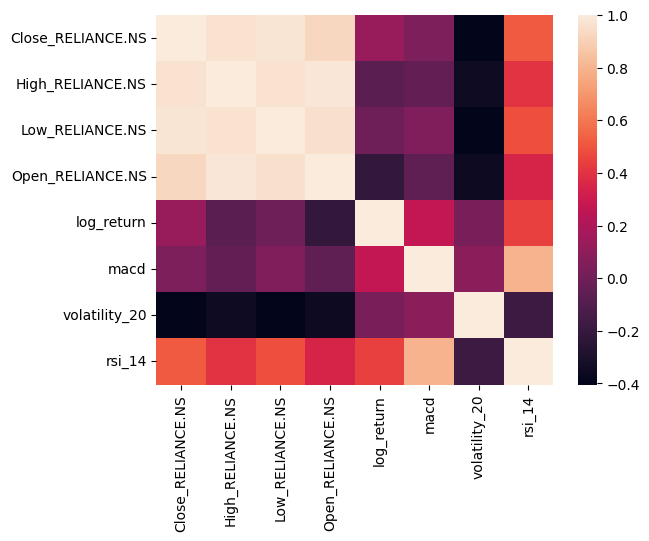

In [226]:
import seaborn as sns
numeric_df = df.select_dtypes(include=["float64"])
correlation = numeric_df.corr()

correlation = numeric_df.corr()
sns.heatmap(correlation)

From the above I found that Close, ma_5 and ma_20 are nearly same therefore can drop them as they may make more noise 


In [227]:
df_final = df

83


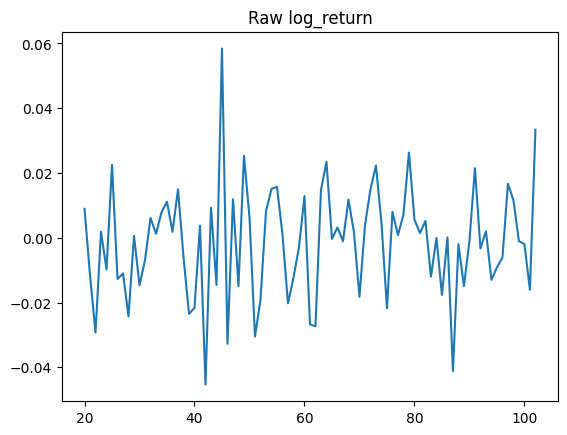

In [228]:
df_final["log_return"].plot(title="Raw log_return")
print(df["log_return"].nunique())


In [229]:
print(df_final["Date_"].dtype)
print(daily_sentiment["Date"].dtype)


datetime64[ns]
object


In [232]:
df_final["Date"] = pd.to_datetime(df_final["Date_"]).dt.date

# Merge sentiment
df_final = df_final.merge(
    sent_daily2,
    on="Date",
    how="left"
)

# Check
df_final[["Date", "sentiment_bucket"]].tail(20)
df_final["sentiment_bucket"] = df_final["sentiment_bucket"].fillna(0)


In [233]:
features = [
    "log_return",          
    "Open_RELIANCE.NS",
    "High_RELIANCE.NS",
    "Low_RELIANCE.NS",
    "Close_RELIANCE.NS",
    "Volume_RELIANCE.NS",
    'sentiment_bucket',
    "rsi_14",


    "macd",
    "volatility_20"
]

df_final["target"] = df_final["log_return"].shift(-1)
df_final = df_final.dropna(subset=["target"])
df_final.head(20)

,Date_,Close_RELIANCE.NS,High_RELIANCE.NS,Low_RELIANCE.NS,Open_RELIANCE.NS,Volume_RELIANCE.NS,log_return,macd,volatility_20,rsi_14,Date,sentiment_num_x,sentiment_bucket_x,sentiment_num_y,sentiment_bucket_y,sentiment_num,sentiment_bucket,target
0,2021-10-19,1243.024536,1251.897291,1232.172556,1239.361675,8833409,0.008916,5.809458,0.012497,83.322226,2021-10-19,NaN,NaN,NaN,NaN,NaN,0.0,-0.011579
1,2021-10-20,1228.714478,1247.984274,1224.664918,1247.984274,12710570,-0.011579,1.240721,0.013138,69.419446,2021-10-20,NaN,NaN,NaN,NaN,NaN,0.0,-0.029272
2,2021-10-21,1193.269043,1241.272811,1184.487276,1240.999848,20831669,-0.029272,-8.888384,0.015228,47.004174,2021-10-21,0.100000,0.0,0.100000,0.0,0.100000,0.0,0.001867
3,2021-10-22,1195.498535,1212.561515,1188.263802,1192.131385,11027475,0.001867,-13.406833,0.014457,48.217669,2021-10-22,-0.333333,-1.0,-0.333333,-1.0,-0.333333,-1.0,-0.009791
4,2021-10-25,1183.850220,1219.432227,1169.380873,1219.432227,17198417,-0.009791,-17.302826,0.014678,42.369088,2021-10-25,-0.166667,0.0,-0.166667,0.0,-0.166667,0.0,0.022517
5,2021-10-26,1210.809814,1214.381688,1184.464631,1190.812114,9750178,0.022517,-13.026560,0.015032,56.469606,2021-10-26,0.100000,0.0,0.100000,0.0,0.100000,0.0,-0.012726
6,2021-10-27,1195.498535,1217.976132,1192.108638,1206.691840,9896298,-0.012726,-13.223731,0.015322,48.666683,2021-10-27,-0.100000,0.0,-0.100000,0.0,-0.100000,0.0,-0.011022
7,2021-10-28,1182.394043,1200.298779,1178.708556,1192.131301,9886181,-0.011022,-15.054557,0.015436,42.823122,2021-10-28,0.100000,0.0,0.100000,0.0,0.100000,0.0,-0.024286
8,2021-10-29,1154.024292,1181.279472,1138.303622,1181.279472,14233025,-0.024286,-20.293969,0.016450,32.942477,2021-10-29,-0.100000,0.0,-0.100000,0.0,-0.100000,0.0,0.000611
9,2021-11-01,1154.729736,1163.010951,1134.845649,1154.024460,15481114,0.000611,-20.962286,0.016447,33.383483,2021-11-01,0.400000,1.0,0.400000,1.0,0.400000,1.0,-0.014687


In [234]:
df_final = df_final.replace([np.inf, -np.inf], np.nan)
df_final = df_final.dropna(subset=features)

In [235]:
print("df rows:", len(df))
print("df_final rows:", len(df_final))

print("\nDuplicate dates in df_final:")
print(df_final["Date_"].value_counts().head(10))


df rows: 83
df_final rows: 82

Duplicate dates in df_final:
Date_
2021-10-19    1
2022-01-14    1
2022-01-12    1
2022-01-11    1
2022-01-10    1
2022-01-07    1
2022-01-06    1
2022-01-05    1
2022-01-04    1
2022-01-03    1
Name: count, dtype: int64


82


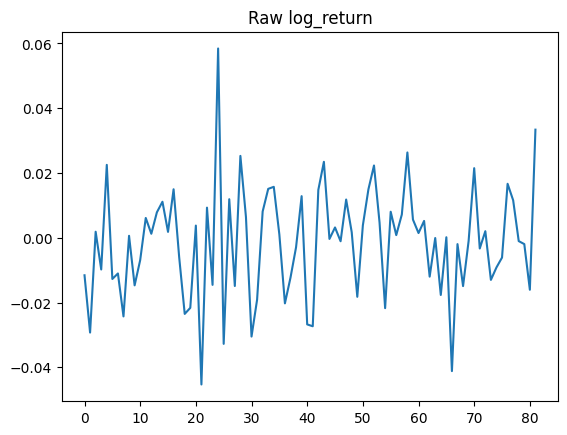

In [236]:
df_final["target"].plot(title="Raw log_return")
print(df_final["target"].nunique())


LSTM Architecture

In [237]:
import torch
import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1, dropout=0.2):
        super(SentimentLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state h0 and cell state c0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        # out shape: (batch_size, seq_length, hidden_dim)
        out, _ = self.lstm(x, (h0, c0))

        # Take output of the last time step
        out = out[:, -1, :]

        # Final prediction
        prediction = self.fc(out)

        return prediction

In [238]:
def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 10

X = df_final[features].values
y = df_final["target"].values

X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

In [239]:
split = int(0.8 * len(X_seq))

X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]


In [240]:
print("X shape:", X.shape)
print("X_seq shape:", X_seq.shape)
print("X_train shape:", X_train.shape)


X shape: (82, 10)
X_seq shape: (72, 10, 10)
X_train shape: (57, 10, 10)


In [241]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (57, 10, 10)
X_val shape: (15, 10, 10)


# Scaling the data by converting the 3D x to 2D and then back to 3D

In [242]:
from sklearn.preprocessing import StandardScaler
# Scale X

n_train, t_train, f_train = X_train.shape
n_val,   t_val,   f_val   = X_val.shape

X_train_2d = X_train.reshape(-1, f_train)
X_val_2d   = X_val.reshape(-1, f_val)

scaler_X = StandardScaler()
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_val_scaled_2d   = scaler_X.transform(X_val_2d)

X_train_s = X_train_scaled_2d.reshape(n_train, t_train, f_train)
X_val_s   = X_val_scaled_2d.reshape(n_val, t_val, f_val)


# Scale y

scaler_y = StandardScaler()

y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()
y_val_s   = scaler_y.transform(y_val.reshape(-1,1)).ravel()





In [243]:
print("scaler_y mean:", scaler_y.mean_)
print("scaler_y scale:", scaler_y.scale_)


scaler_y mean: [-0.00088408]
scaler_y scale: [0.0182365]


Using the self made model

In [250]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


input_dim = X_train.shape[2]     
hidden_dim =128               
num_layers = 2
dropout = 0.2

model = SentimentLSTM(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout = dropout
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cpu


In [251]:
X_train_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
X_val_t   = torch.tensor(X_val_s, dtype=torch.float32).to(device)

y_train_t = torch.tensor(y_train_s, dtype=torch.float32).view(-1, 1).to(device)
y_val_t   = torch.tensor(y_val_s, dtype=torch.float32).view(-1, 1).to(device)




print("X_train shape:", X_train_t.shape)  
print("y_train shape:", y_train_t.shape) 

X_train shape: torch.Size([57, 10, 10])
y_train shape: torch.Size([57, 1])


In [252]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 16

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)


In [253]:
epochs = 60

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    preds = model(X_train_t)
    loss = criterion(preds, y_train_t)

    loss.backward()
    optimizer.step()

    # ---- validation ----
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {loss.item():.6f} | "
        f"Val Loss: {val_loss.item():.6f}"
    )



Epoch 01 | Train Loss: 1.001668 | Val Loss: 0.557457
Epoch 02 | Train Loss: 0.991917 | Val Loss: 0.552541
Epoch 03 | Train Loss: 0.982528 | Val Loss: 0.547673
Epoch 04 | Train Loss: 0.973303 | Val Loss: 0.543413
Epoch 05 | Train Loss: 0.966067 | Val Loss: 0.540542
Epoch 06 | Train Loss: 0.957293 | Val Loss: 0.540328
Epoch 07 | Train Loss: 0.950046 | Val Loss: 0.543606
Epoch 08 | Train Loss: 0.942757 | Val Loss: 0.549838
Epoch 09 | Train Loss: 0.942121 | Val Loss: 0.556501
Epoch 10 | Train Loss: 0.932974 | Val Loss: 0.561416
Epoch 11 | Train Loss: 0.922112 | Val Loss: 0.564525
Epoch 12 | Train Loss: 0.914335 | Val Loss: 0.566331
Epoch 13 | Train Loss: 0.909291 | Val Loss: 0.567341
Epoch 14 | Train Loss: 0.905917 | Val Loss: 0.568510
Epoch 15 | Train Loss: 0.891390 | Val Loss: 0.570895
Epoch 16 | Train Loss: 0.883690 | Val Loss: 0.574754
Epoch 17 | Train Loss: 0.878342 | Val Loss: 0.579579
Epoch 18 | Train Loss: 0.876742 | Val Loss: 0.584960
Epoch 19 | Train Loss: 0.860853 | Val Loss: 0.

In [254]:
# model.eval()
# with torch.no_grad():
#     preds = model(X_val_t).cpu().numpy().flatten()


# actual = y_val_t.cpu().numpy().flatten()
model.eval()
with torch.no_grad():
    preds_scaled = model(X_val_t).cpu().numpy().flatten()

# Inverse scale predictions ONLY
preds_real = scaler_y.inverse_transform(
    preds_scaled.reshape(-1, 1)
).ravel()

# Actual values are already real (next-day returns)
actual_real = y_val





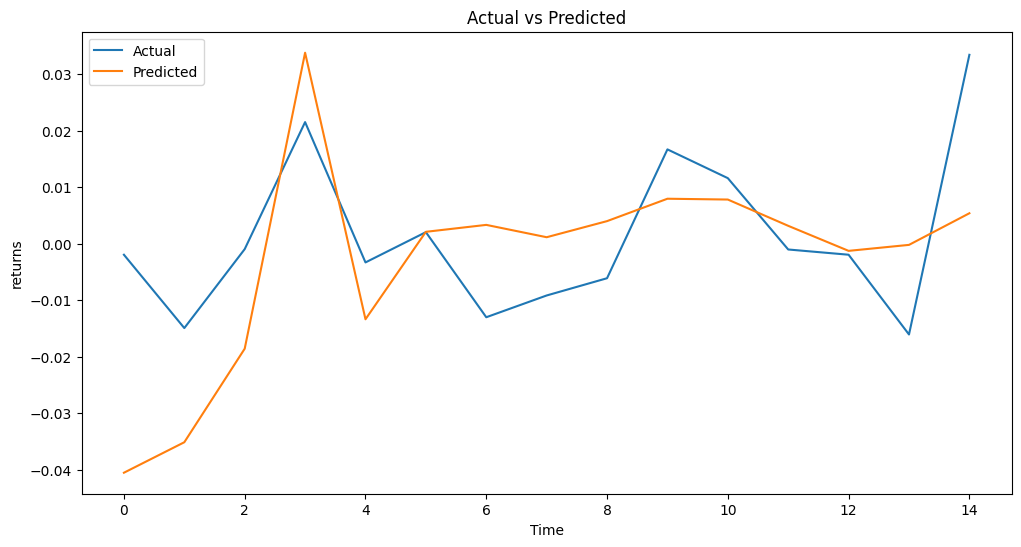

In [255]:
import matplotlib.pyplot as plt
import numpy as np



plt.figure(figsize=(12,6))

# t = np.arange(SEQ_LEN + split, SEQ_LEN + split + len(actual_real))

plt.plot(actual_real, label="Actual")
plt.plot(preds_real, label="Predicted")



plt.xlabel("Time")
plt.ylabel("returns")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()
